**The Data Incubator**

**The Capstone Project: Part 2**

### **Companies' Growth Prediction Using Their LinkedIn and Facebook Account Metrics**
## By Shiva Esna Ashari
November 2021

In the second part of the project, I deal with the data I have for LinkedIn and Facebook data sets as Time Series. I will prepare the data and features and predict the number of employees for each company over time.

For this goal, in order to account for the effect of the industry a company belongs to, the number of empolyees in that industry over time is calculated and added to the features.

Categorical columns are transformed by using OneHotEncoding and a machine learning pipeline is created to run a linear regression on the data and predict the company's growth over time. The prodiction is plotted over time against the actual test data. The results are used to identify the important features that contribute to the analysis. These features are the ones any company should focus on to improve their growth.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import dill

In [2]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
import sklearn.linear_model
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split

## Reading LinkedIn and Facebook Data

In [3]:
!wget "https://s3-us-west-2.amazonaws.com/documents.thinknum.com/dataset_dump/flikerqvnk/temp_datalab_records_linkedin_company.zip"
!unzip temp_datalab_records_linkedin_company.zip
!wget "https://s3-us-west-2.amazonaws.com/documents.thinknum.com/dataset_dump/gnhsjbgeza/temp_datalab_records_social_facebook.zip"
!unzip temp_datalab_records_social_facebook.zip

--2021-11-30 06:50:44--  https://s3-us-west-2.amazonaws.com/documents.thinknum.com/dataset_dump/flikerqvnk/temp_datalab_records_linkedin_company.zip
Resolving s3-us-west-2.amazonaws.com (s3-us-west-2.amazonaws.com)... 52.92.165.128
Connecting to s3-us-west-2.amazonaws.com (s3-us-west-2.amazonaws.com)|52.92.165.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 301331775 (287M) [binary/octet-stream]
Saving to: ‘temp_datalab_records_linkedin_company.zip’

temp_datalab_record 100%[===================>] 287.37M  36.1MB/s    in 8.8s    

2021-11-30 06:50:53 (32.5 MB/s) - ‘temp_datalab_records_linkedin_company.zip’ saved [301331775/301331775]

Archive:  temp_datalab_records_linkedin_company.zip
  inflating: temp_datalab_records_linkedin_company.csv  
--2021-11-30 06:51:03--  https://s3-us-west-2.amazonaws.com/documents.thinknum.com/dataset_dump/gnhsjbgeza/temp_datalab_records_social_facebook.zip
Resolving s3-us-west-2.amazonaws.com (s3-us-west-2.amazonaws.com)... 5

In [4]:
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 100)

## Cleaning up the imported data:

The imported data is cleaned based on the Part 1 of the project:

In [5]:
df_linkedin = pd.read_csv('temp_datalab_records_linkedin_company.csv',dtype={"description": "string","website":"string"})
date_cols = ['as_of_date','date_added', 'date_updated']

for c in date_cols:
    df_linkedin[c] = pd.to_datetime(df_linkedin[c])

#removing the time zone
df_linkedin['date_added'] = pd.to_datetime(df_linkedin.date_added).dt.tz_localize(None)
df_linkedin['date_updated'] = pd.to_datetime(df_linkedin.date_updated).dt.tz_localize(None)
df_linkedin.dtypes

#changing description to known & unknown
df_linkedin['description'].fillna("unknown",inplace=True)
df_linkedin['description'] = df_linkedin['description'].apply(lambda x: "known" if x!="unknown" else "unknown")

df_linkedin = df_linkedin.drop(['entity_id','cusip', 'isin'], axis=1)
df_linkedin['website'].fillna("unknown",inplace=True)
df_linkedin['industry'].fillna("unknown",inplace=True)
#matching dates for both datasets
df_linkedin = df_linkedin.loc[(df_linkedin['as_of_date']>='2015-09-14') & (df_linkedin['as_of_date']<='2018-07-17')]
#dropping date_added and date_updated
df_linkedin = df_linkedin.drop(['date_updated','date_added'], axis=1)
#dropping link
df_linkedin = df_linkedin.drop(['link'], axis=1)
#dropping dataset_id
df_linkedin = df_linkedin.drop(['dataset_id'], axis=1)

Having a description on the LinkedIn page of a company is categorized as "known" and "unknown" since the description was updated for most ogfthe companies and what we care about is whether or not a company has added the description to their page or not.

In [6]:
df_linkedin1 = pd.read_csv('temp_datalab_records_linkedin_company.csv',dtype={"description": "string","website":"string"})
df_linkedin1.description.fillna("unknown",inplace=True)
df_linkedin1['col2'] = df_linkedin1['description'].apply(lambda x: "known" if x!="unknown" else "unknown")
df_linkedin1

,dataset_id,as_of_date,company_name,followers_count,employees_on_platform,link,industry,date_added,date_updated,description,website,entity_id,cusip,isin,col2
0,58329,2015-09-14,Goldman Sachs,552254,38124,https://www.linkedin.com/company/1382,Investment Banking,2015-09-14 00:00:00+00,2015-09-14 00:00:00+00,unknown,<NA>,NaN,NaN,NaN,unknown
1,58329,2015-09-15,Goldman Sachs,552862,38141,https://www.linkedin.com/company/1382,Investment Banking,2015-09-15 00:00:00+00,2015-09-15 00:00:00+00,unknown,<NA>,NaN,NaN,NaN,unknown
2,58363,2015-09-16,United Technologies,59157,14982,https://www.linkedin.com/company/2426,Aviation & Aerospace,2015-09-16 00:00:00+00,2015-09-16 00:00:00+00,unknown,<NA>,NaN,NaN,NaN,unknown
3,58366,2015-09-16,Novo Nordisk,336175,26448,https://www.linkedin.com/company/2227,Pharmaceuticals,2015-09-16 00:00:00+00,2015-09-16 00:00:00+00,unknown,<NA>,NaN,NaN,NaN,unknown
4,58371,2015-09-16,"Lowe's Companies, Inc.",134255,62574,https://www.linkedin.com/company/4128,Retail,2015-09-16 00:00:00+00,2015-09-16 00:00:00+00,unknown,<NA>,NaN,NaN,NaN,unknown
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2426191,902985,2018-07-17,"Diversified Restaurant Holdings, Inc (Nasdaq: ...",488,89,https://www.linkedin.com/company/428083,Restaurants,2018-07-17 17:17:08.8897+00,2018-07-17 17:17:08.889725+00,unknown,http://www.diversifiedrestaurantholdings.com,NaN,NaN,NaN,unknown
2426192,903052,2018-07-17,First Financial Northwest Bank,785,118,https://www.linkedin.com/company/497673,Banking,2018-07-17 15:54:35.807059+00,2018-07-17 15:54:35.807085+00,unknown,http://www.ffnwb.com,NaN,NaN,NaN,unknown
2426193,902948,2018-07-17,DMC Global Inc.,1521,184,https://www.linkedin.com/company/586890,Oil & Energy,2018-07-17 13:44:19.302482+00,2018-07-17 13:44:19.302508+00,unknown,http://www.dmcglobal.com,NaN,NaN,NaN,unknown
2426194,910210,2018-07-17,ServiceSource,27963,2496,https://www.linkedin.com/company/11889,Information Technology and Services,2018-07-17 17:28:48.430667+00,2018-07-17 17:28:48.430717+00,unknown,http://www.servicesource.com,NaN,NaN,NaN,unknown


In [7]:
df_linkedin.description.unique()

array(['unknown', 'known'], dtype=object)

In [8]:
df_linkedin

,as_of_date,company_name,followers_count,employees_on_platform,industry,description,website
0,2015-09-14,Goldman Sachs,552254,38124,Investment Banking,unknown,unknown
1,2015-09-15,Goldman Sachs,552862,38141,Investment Banking,unknown,unknown
2,2015-09-16,United Technologies,59157,14982,Aviation & Aerospace,unknown,unknown
3,2015-09-16,Novo Nordisk,336175,26448,Pharmaceuticals,unknown,unknown
4,2015-09-16,"Lowe's Companies, Inc.",134255,62574,Retail,unknown,unknown
...,...,...,...,...,...,...,...
2426191,2018-07-17,"Diversified Restaurant Holdings, Inc (Nasdaq: ...",488,89,Restaurants,unknown,http://www.diversifiedrestaurantholdings.com
2426192,2018-07-17,First Financial Northwest Bank,785,118,Banking,unknown,http://www.ffnwb.com
2426193,2018-07-17,DMC Global Inc.,1521,184,Oil & Energy,unknown,http://www.dmcglobal.com
2426194,2018-07-17,ServiceSource,27963,2496,Information Technology and Services,unknown,http://www.servicesource.com


In [9]:
df_linkedin = df_linkedin[df_linkedin.industry != 'unknown']
df_linkedin.shape

(2389931, 7)

In [ ]:
# df_linkedin['date_updated'].equals(df_linkedin['date_added'])

At this point, total number of employees in each industry on each date is calculated and later used as a new feature in the analysis.

In [10]:
#getting total number of employees in each industry on each date
industry_data= df_linkedin.groupby(['as_of_date','industry'])['employees_on_platform'].sum()
industry_data.reset_index()
industry_data

as_of_date  industry            
2015-09-14  Investment Banking       38124
2015-09-15  Investment Banking       38141
2015-09-16  Automotive              187205
            Aviation & Aerospace    111255
            Banking                 537181
                                     ...  
2018-07-17  Warehousing                450
            Wholesale                62076
            Wine and Spirits         30594
            Wireless                 49758
            Writing and Editing         26
Name: employees_on_platform, Length: 99426, dtype: int64

In [11]:
df_linkedin2 = pd.merge(df_linkedin, industry_data,  how='left', left_on=['as_of_date','industry'], right_on = ['as_of_date','industry'])
df_linkedin2.columns = ['as_of_date',	'company_name',	'followers_count',	'employees_on_platform',	'industry',	'description',	'website',	'total_industry_employee']
df_linkedin2

,as_of_date,company_name,followers_count,employees_on_platform,industry,description,website,total_industry_employee
0,2015-09-14,Goldman Sachs,552254,38124,Investment Banking,unknown,unknown,38124
1,2015-09-15,Goldman Sachs,552862,38141,Investment Banking,unknown,unknown,38141
2,2015-09-16,United Technologies,59157,14982,Aviation & Aerospace,unknown,unknown,111255
3,2015-09-16,Novo Nordisk,336175,26448,Pharmaceuticals,unknown,unknown,558637
4,2015-09-16,"Lowe's Companies, Inc.",134255,62574,Retail,unknown,unknown,540997
...,...,...,...,...,...,...,...,...
2389926,2018-07-17,"Diversified Restaurant Holdings, Inc (Nasdaq: ...",488,89,Restaurants,unknown,http://www.diversifiedrestaurantholdings.com,543585
2389927,2018-07-17,First Financial Northwest Bank,785,118,Banking,unknown,http://www.ffnwb.com,1499553
2389928,2018-07-17,DMC Global Inc.,1521,184,Oil & Energy,unknown,http://www.dmcglobal.com,1037055
2389929,2018-07-17,ServiceSource,27963,2496,Information Technology and Services,unknown,http://www.servicesource.com,3189055


In [12]:
print(df_linkedin2.head)

<bound method NDFrame.head of         as_of_date                                       company_name  \
0       2015-09-14                                      Goldman Sachs   
1       2015-09-15                                      Goldman Sachs   
2       2015-09-16                                United Technologies   
3       2015-09-16                                       Novo Nordisk   
4       2015-09-16                             Lowe's Companies, Inc.   
...            ...                                                ...   
2389926 2018-07-17  Diversified Restaurant Holdings, Inc (Nasdaq: ...   
2389927 2018-07-17                     First Financial Northwest Bank   
2389928 2018-07-17                                    DMC Global Inc.   
2389929 2018-07-17                                      ServiceSource   
2389930 2018-07-17                                           Attunity   

         followers_count  employees_on_platform  \
0                 552254                  

## Cleaning up the imported data:

The imported data is cleaned based on the Part 1 of the project:

In [13]:
df_facebook = pd.read_csv('temp_datalab_records_social_facebook.csv')
date_cols = ['time','date_added', 'date_updated']

for c in date_cols:
    df_facebook[c] = pd.to_datetime(df_facebook[c])

#removing the time zone
df_facebook['time'] = pd.to_datetime(df_facebook.time).dt.tz_localize(None)
df_facebook['date_added'] = pd.to_datetime(df_facebook.date_added).dt.tz_localize(None)
df_facebook['date_updated'] = pd.to_datetime(df_facebook.date_updated).dt.tz_localize(None)
df_facebook.dtypes

df_facebook = df_facebook.drop(['has_added_app','entity_id','cusip', 'isin'], axis=1)
df_facebook=df_facebook[df_facebook['username'].notna()]
#dropping checkins
df_facebook = df_facebook.drop(['checkins'], axis=1)
#dropping date_added and date_updated
df_facebook = df_facebook.drop(['date_updated','date_added'], axis=1)
#dropping facebook_id
df_facebook = df_facebook.drop(['facebook_id','dataset_id'], axis=1)
#get rid of hours in 'time'
df_facebook['time'] = pd.to_datetime(df_facebook['time']).dt.normalize()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (9) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
# df_facebook['were_here_count'].equals(df_facebook['checkins'])

In [14]:
df_facebook.head

<bound method NDFrame.head of               time              username  were_here_count    likes  \
0       2015-01-01            SodaStream                0   761533   
1       2015-01-01              ANSYSInc                0    43442   
2       2015-01-01         MyAquaAmerica                0     5591   
3       2015-01-01              Qualcomm                0  1232521   
4       2015-01-01  eaglepharmaceuticals                0       18   
...            ...                   ...              ...      ...   
3621386 2018-07-17  SignatureStyleSalons                0      400   
3621387 2018-07-17                tdr.jp           510211  1105124   
3621388 2018-07-17              fiberone                0   576589   
3621389 2018-07-17                PayPal                0  5913042   
3621390 2018-07-17      TorchlightEnergy                0      591   

         talking_about_count  
0                        587  
1                       1305  
2                        297  
3    

In [ ]:
with open('linkedin_dataframe.dill','wb') as f:
    dill.dump(df_linkedin2,f)

with open('facebook_dataframe.dill','wb') as f:
    dill.dump(df_facebook,f)

In [ ]:
with open('linkedin_dataframe.dill','rb') as f:
    df_linkedin2 = dill.load(f)

with open('facebook_dataframe.dill','rb') as f:
    df_facebook = dill.load(f)

#Studying Atlassian company for growth prediction
Atlassian as a mid size tech company which did not have major acquisition over time is selected to study. The data for Atlassian from both LinkedIn and Facebook data sets are obtained and combined using backward filling of the missing data.

In [15]:
df_linkedin_atlassian = df_linkedin2.loc[df_linkedin2['company_name']=='Atlassian']
df_facebook_atlassian = df_facebook.loc[df_facebook['username']=='Atlassian']

In [ ]:
# df_facebook_atlassian['were_here_count'].equals(df_facebook_atlassian['checkins'])

In [ ]:
# df_linkedin_atlassian['date_updated'].equals(df_linkedin_atlassian['date_added'])

In [ ]:
# df_linkedin_atlassian[['date_updated', 'date_added', 'as_of_date']]

In [16]:
df_linkedin_atlassian

,as_of_date,company_name,followers_count,employees_on_platform,industry,description,website,total_industry_employee
82468,2016-04-07,Atlassian,54626,1765,Computer Software,unknown,unknown,327226
83135,2016-04-08,Atlassian,54717,1765,Computer Software,unknown,unknown,327222
83802,2016-04-09,Atlassian,54756,1769,Computer Software,unknown,unknown,327575
84469,2016-04-10,Atlassian,54805,1770,Computer Software,unknown,unknown,327681
85136,2016-04-11,Atlassian,54901,1774,Computer Software,unknown,unknown,327880
...,...,...,...,...,...,...,...,...
2373535,2018-07-13,Atlassian,113318,2891,Computer Software,unknown,http://www.atlassian.com/,648800
2375478,2018-07-14,Atlassian,113338,2890,Computer Software,unknown,http://www.atlassian.com/,649788
2379182,2018-07-15,Atlassian,113412,2889,Computer Software,unknown,http://www.atlassian.com/,652744
2384552,2018-07-16,Atlassian,113492,2890,Computer Software,unknown,http://www.atlassian.com/,652870


In [17]:
print(df_linkedin_atlassian[['as_of_date','industry']])

        as_of_date           industry
82468   2016-04-07  Computer Software
83135   2016-04-08  Computer Software
83802   2016-04-09  Computer Software
84469   2016-04-10  Computer Software
85136   2016-04-11  Computer Software
...            ...                ...
2373535 2018-07-13  Computer Software
2375478 2018-07-14  Computer Software
2379182 2018-07-15  Computer Software
2384552 2018-07-16  Computer Software
2389635 2018-07-17  Computer Software

[818 rows x 2 columns]


In [18]:
df_facebook_atlassian.dtypes

time                   datetime64[ns]
username                       object
were_here_count                 int64
likes                           int64
talking_about_count             int64
dtype: object

In [19]:
df_facebook_atlassian

,time,username,were_here_count,likes,talking_about_count
1196488,2016-11-11,Atlassian,3825,81067,2753
1200895,2016-11-12,Atlassian,3826,81143,2921
1204533,2016-11-13,Atlassian,3825,81228,2659
1206171,2016-11-14,Atlassian,3825,81241,2441
1210727,2016-11-15,Atlassian,3826,81370,2328
...,...,...,...,...,...
3598365,2018-06-13,Atlassian,4041,180496,1485
3605092,2018-07-05,Atlassian,4039,181669,620
3610538,2018-07-11,Atlassian,4042,181905,1286
3613597,2018-07-14,Atlassian,4042,182138,1980


In [20]:
#merging 2 data sets using "nearest" value filling for facebook time 
df_merged_atlassian = pd.merge_asof(left=df_linkedin_atlassian, right=df_facebook_atlassian, left_on='as_of_date', right_on='time', allow_exact_matches=True, direction='backward')
df_merged_atlassian = df_merged_atlassian.drop(['industry'], axis=1)
df_merged_atlassian

,as_of_date,company_name,followers_count,employees_on_platform,description,website,total_industry_employee,time,username,were_here_count,likes,talking_about_count
0,2016-04-07,Atlassian,54626,1765,unknown,unknown,327226,NaT,NaN,NaN,NaN,NaN
1,2016-04-08,Atlassian,54717,1765,unknown,unknown,327222,NaT,NaN,NaN,NaN,NaN
2,2016-04-09,Atlassian,54756,1769,unknown,unknown,327575,NaT,NaN,NaN,NaN,NaN
3,2016-04-10,Atlassian,54805,1770,unknown,unknown,327681,NaT,NaN,NaN,NaN,NaN
4,2016-04-11,Atlassian,54901,1774,unknown,unknown,327880,NaT,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
813,2018-07-13,Atlassian,113318,2891,unknown,http://www.atlassian.com/,648800,2018-07-11,Atlassian,4042.0,181905.0,1286.0
814,2018-07-14,Atlassian,113338,2890,unknown,http://www.atlassian.com/,649788,2018-07-14,Atlassian,4042.0,182138.0,1980.0
815,2018-07-15,Atlassian,113412,2889,unknown,http://www.atlassian.com/,652744,2018-07-14,Atlassian,4042.0,182138.0,1980.0
816,2018-07-16,Atlassian,113492,2890,unknown,http://www.atlassian.com/,652870,2018-07-14,Atlassian,4042.0,182138.0,1980.0


In [21]:
df_merged_atlassian.isna().sum()

as_of_date                   0
company_name                 0
followers_count              0
employees_on_platform        0
description                  0
website                      0
total_industry_employee      0
time                       210
username                   210
were_here_count            210
likes                      210
talking_about_count        210
dtype: int64

The rows that has NaN values for the "time" are removed:

In [22]:
df_merged_atlassian = df_merged_atlassian[df_merged_atlassian['time'].notna()]
df_merged_atlassian

,as_of_date,company_name,followers_count,employees_on_platform,description,website,total_industry_employee,time,username,were_here_count,likes,talking_about_count
210,2016-11-11,Atlassian,69213,1987,unknown,unknown,477768,2016-11-11,Atlassian,3825.0,81067.0,2753.0
211,2016-11-12,Atlassian,69235,1988,unknown,unknown,478010,2016-11-12,Atlassian,3826.0,81143.0,2921.0
212,2016-11-13,Atlassian,69251,1988,unknown,unknown,478182,2016-11-13,Atlassian,3825.0,81228.0,2659.0
213,2016-11-14,Atlassian,69272,1989,unknown,unknown,478355,2016-11-14,Atlassian,3825.0,81241.0,2441.0
214,2016-11-15,Atlassian,69314,1996,unknown,unknown,478766,2016-11-15,Atlassian,3826.0,81370.0,2328.0
...,...,...,...,...,...,...,...,...,...,...,...,...
813,2018-07-13,Atlassian,113318,2891,unknown,http://www.atlassian.com/,648800,2018-07-11,Atlassian,4042.0,181905.0,1286.0
814,2018-07-14,Atlassian,113338,2890,unknown,http://www.atlassian.com/,649788,2018-07-14,Atlassian,4042.0,182138.0,1980.0
815,2018-07-15,Atlassian,113412,2889,unknown,http://www.atlassian.com/,652744,2018-07-14,Atlassian,4042.0,182138.0,1980.0
816,2018-07-16,Atlassian,113492,2890,unknown,http://www.atlassian.com/,652870,2018-07-14,Atlassian,4042.0,182138.0,1980.0


# Studying 3 months prediction for Atlassian:
Seperating train and test data based on the date is done in the next step and the last 3 months of data is used as test data.

In [23]:
df_merged_atlassian_test = df_merged_atlassian.loc[(df_merged_atlassian['as_of_date']>='2018-05-01')]
df_merged_atlassian_trainval = df_merged_atlassian.loc[(df_merged_atlassian['as_of_date']<'2018-05-01')]

In [24]:
df_merged_atlassian_test

,as_of_date,company_name,followers_count,employees_on_platform,description,website,total_industry_employee,time,username,were_here_count,likes,talking_about_count
741,2018-05-01,Atlassian,106166,2754,unknown,http://www.atlassian.com/,633396,2018-05-01,Atlassian,4029.0,178774.0,1808.0
742,2018-05-02,Atlassian,106277,2755,unknown,http://www.atlassian.com/,633724,2018-05-02,Atlassian,4029.0,178791.0,1520.0
743,2018-05-03,Atlassian,106365,2759,unknown,http://www.atlassian.com/,633885,2018-05-03,Atlassian,4029.0,178817.0,1058.0
744,2018-05-04,Atlassian,106424,2757,unknown,http://www.atlassian.com/,633956,2018-05-04,Atlassian,4029.0,178817.0,1100.0
745,2018-05-05,Atlassian,106548,2757,unknown,http://www.atlassian.com/,633462,2018-05-05,Atlassian,4029.0,178829.0,1103.0
746,2018-05-06,Atlassian,106616,2760,unknown,http://www.atlassian.com/,634137,2018-05-06,Atlassian,4029.0,178848.0,1117.0
747,2018-05-07,Atlassian,106716,2761,unknown,http://www.atlassian.com/,635248,2018-05-07,Atlassian,4029.0,178881.0,1124.0
748,2018-05-08,Atlassian,106828,2764,unknown,http://www.atlassian.com/,635007,2018-05-08,Atlassian,4030.0,178913.0,1112.0
749,2018-05-09,Atlassian,106931,2770,unknown,http://www.atlassian.com/,635145,2018-05-09,Atlassian,4030.0,178932.0,1129.0
750,2018-05-10,Atlassian,106997,2771,unknown,http://www.atlassian.com/,635917,2018-05-10,Atlassian,4026.0,178938.0,1026.0


In [25]:
y_test = df_merged_atlassian_test['employees_on_platform']
X_test = df_merged_atlassian_test.drop(['as_of_date','time', 'company_name', 'username','employees_on_platform'], axis=1)
# X_test
y_trainval = df_merged_atlassian_trainval['employees_on_platform']
X_trainval = df_merged_atlassian_trainval.drop(['as_of_date','time', 'company_name', 'username','employees_on_platform'], axis=1)

In [ ]:
#X_train, X_valid, y_train, y_valid = train_test_split(X_trainval , y_trainval, test_size=0.2, random_state=0)

By using OneHotEncoding, categorical columns are converted to numerical columns and a pipeline is created for a Ridge model.

In [26]:
categorical_columns = ['description','website']
features = ColumnTransformer([
('categorical', OneHotEncoder(), categorical_columns)],
remainder='passthrough')

est = Pipeline([      
('features', features),
('regressor', Ridge())
])

After fitting the model, the prediction is done for the test data and the score is obtained:

In [27]:
est.fit(X_trainval,y_trainval)
p=est.predict(X_test)
p

array([2763.75030693, 2765.94568563, 2767.76184291, 2768.86537841,
       2771.21728498, 2772.5448716 , 2774.51237494, 2775.95240614,
       2777.92999425, 2782.15565851, 2784.65517914, 2786.09369695,
       2786.64892783, 2787.74215644, 2788.85603575, 2790.18186622,
       2792.07225454, 2794.2795766 , 2792.39723018, 2793.52198428,
       2795.25870733, 2798.55001011, 2800.71699124, 2802.73348475,
       2804.99625009, 2805.731679  , 2806.87260731, 2808.03153117,
       2810.59751336, 2813.13583312, 2814.94543381, 2815.79798702,
       2817.24804776, 2818.77589402, 2820.33811892, 2821.38984756,
       2823.26751694, 2825.475924  , 2829.3187927 , 2830.69607729,
       2831.65819522, 2833.96007652, 2835.63938868, 2837.31038195,
       2838.32846935, 2841.610177  , 2843.47658561, 2844.40085351,
       2845.11739012, 2848.72401253, 2849.4958262 , 2853.21108298,
       2855.15282998, 2858.51326276, 2860.38343627, 2862.31217686,
       2864.95616598, 2867.16708845, 2867.84787942, 2869.47132

In [28]:
est.score(X_test, y_test)

0.9516598342828565

Calculating feature importance for the model:

In [29]:
coefficients = est.named_steps['regressor'].coef_
coefficients

array([-2.47515102e+01,  2.47515102e+01,  1.02047682e+01, -1.02047682e+01,
        1.88428144e-02,  1.64405872e-05, -7.33575899e-01,  2.01563784e-03,
       -2.22805393e-04])

In [30]:
importance = np.abs(coefficients)
importance

array([2.47515102e+01, 2.47515102e+01, 1.02047682e+01, 1.02047682e+01,
       1.88428144e-02, 1.64405872e-05, 7.33575899e-01, 2.01563784e-03,
       2.22805393e-04])

In [31]:
column_names = X_test.columns
column_names

Index(['followers_count', 'description', 'website', 'total_industry_employee',
       'were_here_count', 'likes', 'talking_about_count'],
      dtype='object')

In [32]:
column_importance = {}
column_importance['followers_count'] = importance[0]
column_importance['description_yes'] = importance[1]
column_importance['description_no'] = importance[2]
column_importance['website_yes'] = importance[3]
column_importance['website_no'] = importance[4]
column_importance['total_industry_employee'] = importance[5]
column_importance['were_here_count'] = importance[6]
column_importance['likes'] = importance[7]
column_importance['talking_about_count'] = importance[8]
column_importance

{'description_no': 10.204768228976846,
 'description_yes': 24.751510217012985,
 'followers_count': 24.751510217012633,
 'likes': 0.0020156378420987118,
 'talking_about_count': 0.00022280539313448993,
 'total_industry_employee': 1.6440587185982544e-05,
 'website_no': 0.01884281437086365,
 'website_yes': 10.204768228978265,
 'were_here_count': 0.7335758993567045}

It can be seen that Facebook metrics of "number of likes" "number of talking about counts" are not as important as LinkedIn metrics such as "followers counts" and having a "website describtion". In addition, the change in the number of employees for the industry of a company does't contribute much to the company's growth.

In [ ]:
# sorted_importance = sorted(column_importance, key = lambda x: x[1], reverse=True)
# sorted_importance = {k: v for k, v in sorted(column_importance.items(), key=lambda item: -item[1])}
# sorted_importance = dict(sorted(column_importance.items(), key = lambda item: -item[1]))
# sorted_importance

In [33]:
features.named_transformers_['categorical'].categories_

[array(['known', 'unknown'], dtype=object),
 array(['http://www.atlassian.com/', 'unknown'], dtype=object)]

Plotting the results to compare the prediction against test data:

In [34]:
plt.rc('legend',**{'fontsize':20})
width=4

In [35]:
data = [df_merged_atlassian_test["as_of_date"], df_merged_atlassian_test["employees_on_platform"]]
headers = ["as_of_date", "employees_on_platform"]
df_data = pd. concat(data, axis=1, keys=headers)

data2 = [df_merged_atlassian_trainval["as_of_date"], df_merged_atlassian_trainval["employees_on_platform"]]
df_data2 = pd. concat(data2, axis=1, keys=headers)

df_p = pd.DataFrame(p, columns = ['employees_on_platform'])
df_p_time = df_merged_atlassian_test["as_of_date"]
df_p_time = df_p_time.reset_index()
data3 = [df_p_time["as_of_date"], df_p["employees_on_platform"]]
df_data3 = pd. concat(data3, axis=1, keys=headers)

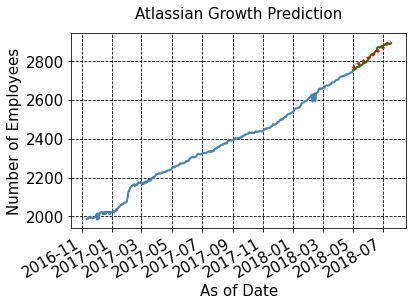

In [36]:
ax = plt.gca()
df_data.plot(x='as_of_date', y='employees_on_platform', legend=None, color='green',linewidth=2, ax=ax)
df_data2.plot(x='as_of_date', y='employees_on_platform', legend=None, color='steelblue',linewidth=2, ax=ax)
df_data3.plot(x='as_of_date', y='employees_on_platform', legend=None, color='red',linewidth=3, ax=ax, ls="--", dashes=(1, 1))

plt.grid(color='black', linestyle='dashed')
plt.xlabel('As of Date', fontsize=15)
plt.ylabel('Number of Employees', fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.title("Atlassian Growth Prediction", fontsize=15, y=1.04)

plt.show()

# Studying 6 months prediction for Atlassian:

In order to evaluate the model for longer time, the time window for the test data is set as the last 6 months of the data and the model is run again:

In [37]:
df_merged_atlassian_test2 = df_merged_atlassian.loc[(df_merged_atlassian['as_of_date']>='2018-03-08')]
df_merged_atlassian_trainval2 = df_merged_atlassian.loc[(df_merged_atlassian['as_of_date']<'2018-03-08')]

y_test = df_merged_atlassian_test2['employees_on_platform']
X_test = df_merged_atlassian_test2.drop(['as_of_date','time', 'company_name', 'username','employees_on_platform'], axis=1)
# X_test
y_trainval = df_merged_atlassian_trainval2['employees_on_platform']
X_trainval = df_merged_atlassian_trainval2.drop(['as_of_date','time', 'company_name', 'username','employees_on_platform'], axis=1)

categorical_columns = ['description','website']
features = ColumnTransformer([
('categorical', OneHotEncoder(), categorical_columns)],
remainder='passthrough')

est = Pipeline([      
('features', features),
('regressor', Ridge())
])


est.fit(X_trainval,y_trainval)
p=est.predict(X_test)
est.score(X_test, y_test)

0.9708180125474006

Similar result is obtained for a longer test data sets of 6 months.

In [38]:
X_trainval.website.unique()

<StringArray>
['unknown', 'http://www.atlassian.com/']
Length: 2, dtype: string

In [39]:
coefficients = est.named_steps['regressor'].coef_
importance = np.abs(coefficients)

column_importance = {}
column_importance['followers_count'] = importance[0]
column_importance['description_yes'] = importance[1]
column_importance['description_no'] = importance[2]
column_importance['website_yes'] = importance[3]
column_importance['website_no'] = importance[4]
column_importance['total_industry_employee'] = importance[5]
column_importance['were_here_count'] = importance[6]
column_importance['likes'] = importance[7]
column_importance['talking_about_count'] = importance[8]
column_importance

{'description_no': 9.112293834185582,
 'description_yes': 24.731972385375478,
 'followers_count': 24.73197238536689,
 'likes': 0.002053358674044737,
 'talking_about_count': 0.00023287840941947744,
 'total_industry_employee': 1.593803914015539e-05,
 'website_no': 0.019475002244325138,
 'website_yes': 9.112293834185763,
 'were_here_count': 0.8247343062005755}

Similar feature importance as the 3 months model is obtained. Next the predicted results are plotted:

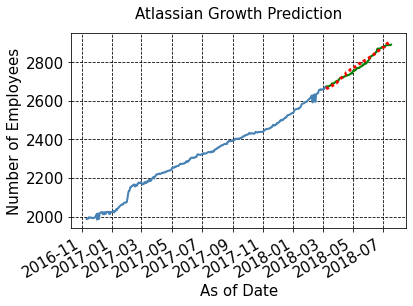

In [40]:
data = [df_merged_atlassian_test2["as_of_date"], df_merged_atlassian_test2["employees_on_platform"]]
headers = ["as_of_date", "employees_on_platform"]
df_data = pd. concat(data, axis=1, keys=headers)

data2 = [df_merged_atlassian_trainval2["as_of_date"], df_merged_atlassian_trainval2["employees_on_platform"]]
df_data2 = pd. concat(data2, axis=1, keys=headers)

df_p = pd.DataFrame(p, columns = ['employees_on_platform'])
df_p_time = df_merged_atlassian_test2["as_of_date"]
df_p_time = df_p_time.reset_index()
data3 = [df_p_time["as_of_date"], df_p["employees_on_platform"]]
df_data3 = pd. concat(data3, axis=1, keys=headers)


ax = plt.gca()
df_data.plot(x='as_of_date', y='employees_on_platform', legend=None, color='green',linewidth=2, ax=ax)
df_data2.plot(x='as_of_date', y='employees_on_platform', legend=None, color='steelblue',linewidth=2, ax=ax)
df_data3.plot(x='as_of_date', y='employees_on_platform', legend=None, color='red',linewidth=3, ax=ax, ls="--", dashes=(1, 1))

plt.grid(color='black', linestyle='dashed')
plt.xlabel('As of Date', fontsize=15)
plt.ylabel('Number of Employees', fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.title("Atlassian Growth Prediction", fontsize=15, y=1.04)

plt.show()

# Studying 6 months prediction for Qualcomm:

To evaluate the performance of the model, Qualcomm which is another mid-size tech company is selected and the model is used to predict the growth over the last 6 months of the data:

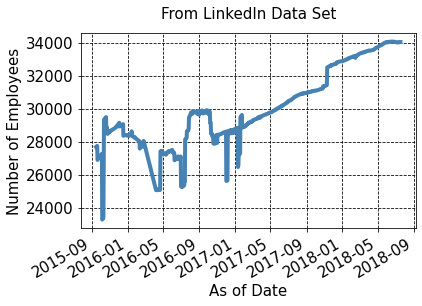

In [41]:
df_linkedin_company2 = df_linkedin2.loc[df_linkedin2['company_name']=='Qualcomm']


df_linkedin_company2.plot(x='as_of_date', y='employees_on_platform', legend=None, color='steelblue',linewidth=width)

plt.grid(color='black', linestyle='dashed')
plt.xlabel('As of Date', fontsize=15)
plt.ylabel('Number of Employees', fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.title("From LinkedIn Data Set", fontsize=15, y=1.04)

plt.show()

In [42]:
df_facebook_company2 = df_facebook.loc[df_facebook['username']=='Qualcomm']

df_merged_company2 = pd.merge_asof(left=df_linkedin_company2, right=df_facebook_company2, left_on='as_of_date', right_on='time', allow_exact_matches=True, direction='backward')
df_merged_company2 = df_merged_company2.drop(['industry'], axis=1)

In [43]:
df_merged_company2.isna().sum()

as_of_date                 0
company_name               0
followers_count            0
employees_on_platform      0
description                0
website                    0
total_industry_employee    0
time                       0
username                   0
were_here_count            0
likes                      0
talking_about_count        0
dtype: int64

In [44]:
df_merged_company2 = df_merged_company2[df_merged_company2['time'].notna()]

In [45]:
df_merged_company2_test2 = df_merged_company2.loc[(df_merged_company2['as_of_date']>='2018-03-08')]
df_merged_company2_trainval2 = df_merged_company2.loc[(df_merged_company2['as_of_date']<'2018-03-08')]

y_test = df_merged_company2_test2['employees_on_platform']
X_test = df_merged_company2_test2.drop(['as_of_date','time', 'company_name', 'username','employees_on_platform'], axis=1)
# X_test
y_trainval = df_merged_company2_trainval2['employees_on_platform']
X_trainval = df_merged_company2_trainval2.drop(['as_of_date','time', 'company_name', 'username','employees_on_platform'], axis=1)

categorical_columns = ['description','website']
features = ColumnTransformer([
('categorical', OneHotEncoder(), categorical_columns)],
remainder='passthrough')

est = Pipeline([      
('features', features),
('regressor', Ridge())
])


est.fit(X_trainval,y_trainval)
p=est.predict(X_test)
est.score(X_test, y_test)

0.7640962081334818

The model performance for Qualcomm is not as good as the Atlassian but it is acceptable. 

In [46]:
coefficients = est.named_steps['regressor'].coef_
importance = np.abs(coefficients)

column_importance = {}
column_importance['followers_count'] = importance[0]
column_importance['description_yes'] = importance[1]
column_importance['description_no'] = importance[2]
column_importance['website_yes'] = importance[3]
column_importance['website_no'] = importance[4]
column_importance['total_industry_employee'] = importance[5]
column_importance['were_here_count'] = importance[6]
column_importance['likes'] = importance[7]
column_importance['talking_about_count'] = importance[8]
column_importance

{'description_no': 218.67253839566314,
 'description_yes': 110.63042415521537,
 'followers_count': 110.63042415506547,
 'likes': 0.0044941426281534125,
 'talking_about_count': 0.01345849445805306,
 'total_industry_employee': 0.1793379096049824,
 'website_no': 0.03210325499496246,
 'website_yes': 218.67253839566308,
 'were_here_count': 0.0}

Feature importance is similar for Qualcomm compared to Atlassian. The predicted results are plotted next:

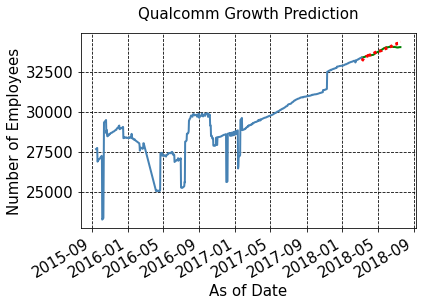

In [47]:
data = [df_merged_company2_test2["as_of_date"], df_merged_company2_test2["employees_on_platform"]]
headers = ["as_of_date", "employees_on_platform"]
df_data = pd. concat(data, axis=1, keys=headers)

data2 = [df_merged_company2_trainval2["as_of_date"], df_merged_company2_trainval2["employees_on_platform"]]
df_data2 = pd. concat(data2, axis=1, keys=headers)

df_p = pd.DataFrame(p, columns = ['employees_on_platform'])
df_p_time = df_merged_company2_test2["as_of_date"]
df_p_time = df_p_time.reset_index()
data3 = [df_p_time["as_of_date"], df_p["employees_on_platform"]]
df_data3 = pd. concat(data3, axis=1, keys=headers)


ax = plt.gca()
df_data.plot(x='as_of_date', y='employees_on_platform', legend=None, color='green',linewidth=2, ax=ax)
df_data2.plot(x='as_of_date', y='employees_on_platform', legend=None, color='steelblue',linewidth=2, ax=ax)
df_data3.plot(x='as_of_date', y='employees_on_platform', legend=None, color='red',linewidth=3, ax=ax, ls="--", dashes=(1, 1))

plt.grid(color='black', linestyle='dashed')
plt.xlabel('As of Date', fontsize=15)
plt.ylabel('Number of Employees', fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.title("Qualcomm Growth Prediction", fontsize=15, y=1.04)

plt.show()

# Studying 6 months prediction for Etsy:

To evaluate the performance of the model, Qualcomm which is another mid-size  company is selected and the model is used to predict the growth over the last 6 months of the data:

In [48]:
df_linkedin_company2 = df_linkedin2.loc[df_linkedin2['company_name']=='Etsy']
df_facebook_company2 = df_facebook.loc[df_facebook['username']=='Etsy']

df_merged_company2 = pd.merge_asof(left=df_linkedin_company2, right=df_facebook_company2, left_on='as_of_date', right_on='time', allow_exact_matches=True, direction='backward')
df_merged_company2 = df_merged_company2.drop(['industry'], axis=1)

df_merged_company2 = df_merged_company2[df_merged_company2['time'].notna()]

df_merged_company2_test2 = df_merged_company2.loc[(df_merged_company2['as_of_date']>='2018-03-08')]
df_merged_company2_trainval2 = df_merged_company2.loc[(df_merged_company2['as_of_date']<'2018-03-08')]

y_test = df_merged_company2_test2['employees_on_platform']
X_test = df_merged_company2_test2.drop(['as_of_date','time', 'company_name', 'username','employees_on_platform'], axis=1)
# X_test
y_trainval = df_merged_company2_trainval2['employees_on_platform']
X_trainval = df_merged_company2_trainval2.drop(['as_of_date','time', 'company_name', 'username','employees_on_platform'], axis=1)

categorical_columns = ['description','website']
features = ColumnTransformer([
('categorical', OneHotEncoder(), categorical_columns)],
remainder='passthrough')

est = Pipeline([      
('features', features),
('regressor', Ridge())
])


est.fit(X_trainval,y_trainval)
p=est.predict(X_test)
est.score(X_test, y_test)

0.8832965486764581

In [49]:
coefficients = est.named_steps['regressor'].coef_
importance = np.abs(coefficients)

column_importance = {}
column_importance['followers_count'] = importance[0]
column_importance['description_yes'] = importance[1]
column_importance['description_no'] = importance[2]
column_importance['website_yes'] = importance[3]
column_importance['website_no'] = importance[4]
column_importance['total_industry_employee'] = importance[5]
column_importance['were_here_count'] = importance[6]
column_importance['likes'] = importance[7]
column_importance['talking_about_count'] = importance[8]
column_importance

{'description_no': 8.34369144756334,
 'description_yes': 22.440672919175487,
 'followers_count': 22.44067291917997,
 'likes': 0.0006421854303403369,
 'talking_about_count': 2.157935227421737e-05,
 'total_industry_employee': 0.0006730889408350081,
 'website_no': 0.03209404106450709,
 'website_yes': 8.343691447563165,
 'were_here_count': 0.0}

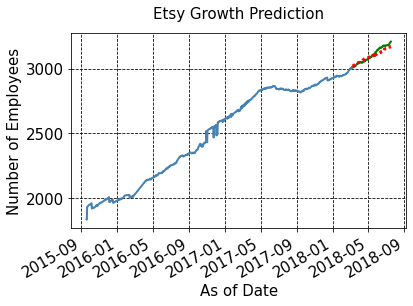

In [50]:
data = [df_merged_company2_test2["as_of_date"], df_merged_company2_test2["employees_on_platform"]]
headers = ["as_of_date", "employees_on_platform"]
df_data = pd. concat(data, axis=1, keys=headers)

data2 = [df_merged_company2_trainval2["as_of_date"], df_merged_company2_trainval2["employees_on_platform"]]
df_data2 = pd. concat(data2, axis=1, keys=headers)

df_p = pd.DataFrame(p, columns = ['employees_on_platform'])
df_p_time = df_merged_company2_test2["as_of_date"]
df_p_time = df_p_time.reset_index()
data3 = [df_p_time["as_of_date"], df_p["employees_on_platform"]]
df_data3 = pd. concat(data3, axis=1, keys=headers)


ax = plt.gca()
df_data.plot(x='as_of_date', y='employees_on_platform', legend=None, color='green',linewidth=2, ax=ax)
df_data2.plot(x='as_of_date', y='employees_on_platform', legend=None, color='steelblue',linewidth=2, ax=ax)
df_data3.plot(x='as_of_date', y='employees_on_platform', legend=None, color='red',linewidth=3, ax=ax, ls="--", dashes=(1, 1))

plt.grid(color='black', linestyle='dashed')
plt.xlabel('As of Date', fontsize=15)
plt.ylabel('Number of Employees', fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.title("Etsy Growth Prediction", fontsize=15, y=1.04)

plt.show()

Again, it was seen that the model performance was acceptable and the feature importance is similar to the other two companies.

## Conclusions:

Based on the results, a Ridge model used for time series analysis can provide acceptable predictions over time.

It was observed that Linkedin metrics play a very important role in growth prediction of a company while the Facebook metrics are not very important. Any company should focus on their LinkedIn page, try to get more followers by having an updated page which has their company's description and website. Sharing interesting content and being active by reaction to interesting posts could be the options a company can have to get more followers. 

It was observed that the Facebook metrics or the number of employees in an industry don't contribute much to the growth of the company. As a result, a company could focus more on their Linkedin account rather than their Facebook page.